In [1]:
function generateBigramMatrix(filename)
    #Read the text file
    text = lowercase(readstring(filename))
    
    alphabet = [' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','*']
    alphabet_size = length(alphabet)
    
    #Dictionary for the frequency counts for pairs (x,y) (the keys) 
    #and the value being the frequency count
    frequency_count = Dict()

    #Loop through the whole text and update frequency count
    for i = 2:length(text)
        
        #current character
        x = text[i-1]
        
        if (x < 'a' || x > 'z') && x != ' '
            x = '*'
        end
        
        #next character 
        y = text[i]
        if (y < 'a' || y > 'z') && y != ' '
            y = '*'
        end
        
        #Update frequency count table (or add key if not seen before)
        if haskey(frequency_count, (x,y))
            frequency_count[(x,y)] +=1
        else
            frequency_count[(x,y)] = 1
        end
            
    end
        
    #Initiate the bigram matrix    
    M = zeros(alphabet_size, alphabet_size)
        
    for i = 1:alphabet_size
        row_total = 0
        for j = 1:alphabet_size
            x = alphabet[i]
            y = alphabet[j]
            #If the particular transition was seen the change the entry to non-zero
            if haskey(frequency_count, (x,y))
                M[i,j] = float(frequency_count[(x,y)])+1
            else
                M[i,j] = 1
            end
            row_total += M[i,j]
        end
        for j = 1:alphabet_size
            M[i,j] = M[i,j]/float(row_total)
        end
        
    end
    return M
    
   
end

generateBigramMatrix (generic function with 1 method)

In [2]:
generateBigramMatrix("english.txt")

28×28 Array{Float64,2}:
 0.0313048    0.114584     0.0414677    …  0.000217152  0.018321   
 0.0595969    4.3763e-5    0.0181589       0.00204865   0.0164303  
 0.00262638   0.0838056    0.00590539      1.59175e-5   0.00270597 
 0.00853385   0.119548     9.27592e-6      0.00020407   0.00324657 
 0.525694     0.0217313    0.000145848     1.94464e-5   0.121515   
 0.289752     0.0441033    0.000859551  …  0.000550257  0.0707458  
 0.319423     0.0688158    0.0002908       1.03857e-5   0.049623   
 0.3457       0.0620239    2.17019e-5      4.34037e-5   0.0936869  
 0.0759473    0.162907     0.000313308     3.33307e-6   0.0228948  
 0.0336164    0.0176232    0.00722111      0.00322833   0.00968816 
 0.000230256  0.0543403    0.000230256  …  0.000230256  0.0020723  
 0.171716     0.052906     0.000279791     2.54356e-5   0.0783925  
 0.101226     0.0773004    0.000857559     0.000160078  0.0373381  
 ⋮                                      ⋱                          
 0.0546247    0.114025  

In [3]:
using Combinatorics

function encryptText(text)
    input_text = lowercase(text)
    f = randperm(28)
    alphabet = [' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','*']
    
    alph_to_numb = Dict{Char, Int64}()
    for i = 1:length(alphabet)
        alph_to_numb[alphabet[i]] = i
    end
    
    output_text = Array{Char,1}(length(input_text))
    
    for i = 1:length(input_text)
        x = input_text[i]
        if (x >= 'a' && x <= 'z') || x == ' '
            output_text[i] = alphabet[f[alph_to_numb[x]]]
        else
            output_text[i] = alphabet[f[alph_to_numb['*']]]
        end
    end
    
    #println(String(output_text))
    return String(output_text)
end

#Note here that functions are represented as arrays
#The text input is the not actual text but an array where the letter that was in the ith place
#has been replaced by its corresponding number (Here think of the alphabet as being 1, . . ., m)
function calculatePlausaibility(M,f,text)
    pl = BigFloat(1)
    for i = 1:(length(text)-1)
        pl *= BigFloat(M[f[text[i]],f[text[i+1]]])
    end
    
    return pl
end

function calcBit(p)
    if 2*p >= 1
        return 1
    else
        return 0
    end
end

function flipCoin(p)
    if p == 1
        return 1
    end
    rand_bit = rand(1:2)-1
    p_bit = calcBit(p)
    while rand_bit != 1
        rand_bit = rand(1:2)-1
        p=(2*p)%1
        p_bit = calcBit(p)
    end
    return p_bit
end



function randomTransposition(f,m)
    i = rand(1:m)
    j = rand(1:m)
    while j == i
        j = rand(1:m)
    end
    
    temp = f[i]
    f[i] = f[j]
    f[j] = temp
    
    return f
end

function decryptText(input_text,filename, numb_steps, numb_tries)
    
    input_text = lowercase(input_text)
    alphabet = [' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','*']
    n = length(alphabet)
    
    alph_to_numb = Dict{Char, Int64}()
    for i = 1:length(alphabet)
        alph_to_numb[alphabet[i]] = i
    end

    text = Array{Int64,1}(length(input_text))
    for i = 1:length(text)
        x = input_text[i]
        if (x >= 'a' && x <= 'z') || x == ' '
            text[i] = alph_to_numb[input_text[i]]
        else
            text[i] = n
        end
    end
    
    M = generateBigramMatrix(filename)   
    
    max_pl = 0
    max_f = Array{Int64,1}(n)
    iter = 0
    for j = 1:numb_tries
        (pl,f, i_prime) = runMCM(alphabet,text,M, numb_steps)
        iter += i_prime
        #println("Last attempt decryption")
        #for i = 1:length(text)
        #    print(alphabet[f[text[i]]])
        #end
        
        #println()
        #println()
        if pl > max_pl
            max_pl = pl
            for k = 1:length(f)
                max_f[k]=f[k]
            end
        end
    end
    
    iter = Float64(iter)/Float64(numb_tries)
    
    output_text = Array{Char,1}(length(text))
    
    #println("Best decryption:")
    #println(max_pl)
    for i = 1:length(text)
        #print(alphabet[max_f[text[i]]])
        output_text[i] = alphabet[max_f[text[i]]]
    end
    #println()
    
    #print("Average i = ")
    #println(iter)
    
    #println()
    
    return output_text
    
    
        
end
   
function runMCM(alphabet, text, M, numb_steps)
    n = length(alphabet)
    f = randperm(n)
    #println(f)
    
    pl = calculatePlausaibility(M,f,text)
    
    max_pl = pl
    max_f = Array{Int64,1}(length(f))
    
    #println("Starting trial")
    count = 0
    i = 0
    while count < numb_steps
        i += 1
        f_star = Array{Int64,1}(length(f))
        for j = 1:length(f)
            f_star[j] = f[j]
        end
        f_star = randomTransposition(f_star,n)
        pl_star = calculatePlausaibility(M,f_star,text)
        
        if pl_star > pl
            pl = pl_star
            f = f_star
            count += 1
        elseif flipCoin(pl_star/pl) == 1
            pl = pl_star
            f = f_star
            count += 1
        end
        
        if pl > max_pl
            max_pl = pl
            for j = 1:length(f)
                max_f[j] = f[j]
            end
            
            #for i = 1:length(text)
            #    print(alphabet[max_f[text[i]]])
            #end
            #println()
            #println()
        end
        
        
    end
    
    #println("finished")
    
    return (max_pl, max_f, i)
end

runMCM (generic function with 1 method)

In [16]:
et = encryptText("President Trump said on Friday that he had not yet spoken to the new acting attorney general, Matthew G. Whitaker, about the special counsel investigation, and he distanced himself from Mr. Whitaker long considered one of the president's loyalists by suggesting that he did not know him.")

"euikr*ifmamusdeakxr*ayfanur*xtamcxmaciacx*afymatimakeyjifamyamciafizaxlmrfhaxmmyufitahifiuxqbadxmmcizahbazcrmxjiubax ysmamciakeilrxqalysfkiqarfpikmrhxmryfbaxf*acia*rkmxfli*acrdkiqnanuydadubazcrmxjiuaqyfhalyfkr*iui*ayfiaynamciaeuikr*ifmbkaqytxqrkmka takshhikmrfhamcxmacia*r*afymajfyzacrdb"

In [17]:
output = decryptText(et,"english.txt",2000,2)
print(String(output))

president trump said on friday that he had not yet spoven to the new acting attorney general* matthew g* whitaver* about the special counsel inkestigation* and he distanced himself from mr* whitaver long considered one of the president*s loyalists by suggesting that he did not vnow him*

In [ ]:
function countDifference(A,B)
    count = 0
    for i = 1:length(A)
        if A[i] == B[i]
            count += 1
        end
    end
    return count
end

In [3]:
using PyPlot


        

function runSims(filename,k,numb_steps, numb_tries)
    english_reference = "/Users/rishi/Downloads/english.txt"
    whole_text = readstring(filename)
    
    println("Number of steps: "*string(numb_steps)*" Number of tries: "*string(numb_tries))
    
    percentage_correct = Array{Float64,1}(k)
    average_iterations = Array{Float64,1}(k)
    for i = 1:k
        text = whole_text[1:(i*100)]
        #println("Using text:")
        #println(text)
        #println("Encrypting text. . .")
        encrypted_text = encryptText(text)
        #println("Decrypting text. . .")
        (decrypted_text, iter) = decryptText(encrypted_text,english_reference, numb_steps, numb_tries)
        percentage_correct[i] = Float64(countDifference(text, decrypted_text))/Float64(i)
        #print("Percentage correct:")
        #println(percentage_correct[i])
        
        average_iterations[i] = iter
    end
    
    generatePlot(percentage_correct, average_iterations)
end

function generatePlot(y1,y2)
    k = length(y1)
    x = Array{Int64,1}(k)
    for i = 1:k
        x[i]=i*100
    end
    
    fig = figure("pyplot_errorbar",figsize=(10,10)) # Create a new figure
    
    subplot(211)
    p = plot(x,y1,linestyle="-",marker="None",label="Base Plot") # Basic line plot
    
    axis("tight")
    ax = gca() # Get the handle of the current axis
    title("Percentage correct vs length")
    xlabel("Length")
    ylabel("Percentage Correct")
    grid("on")
    
    fig[:canvas][:draw]() # Update the figure
    
    subplot(212)
    fig2 = figure("pyplot_errorbar",figsize=(10,10)) # Create a new figure
    p2 = plot(x,y2,linestyle="-",marker="None",label="Base Plot") # Basic line plot
    
    axis("tight")
    ax2 = gca() # Get the handle of the current axis
    title("Average number of iterations vs length")
    xlabel("Length")
    ylabel("Average number of iterations")
    grid("on")
    
    fig2[:canvas][:draw]() # Update the figure
end
        
        
        
        
        
    
    

generatePlot (generic function with 1 method)

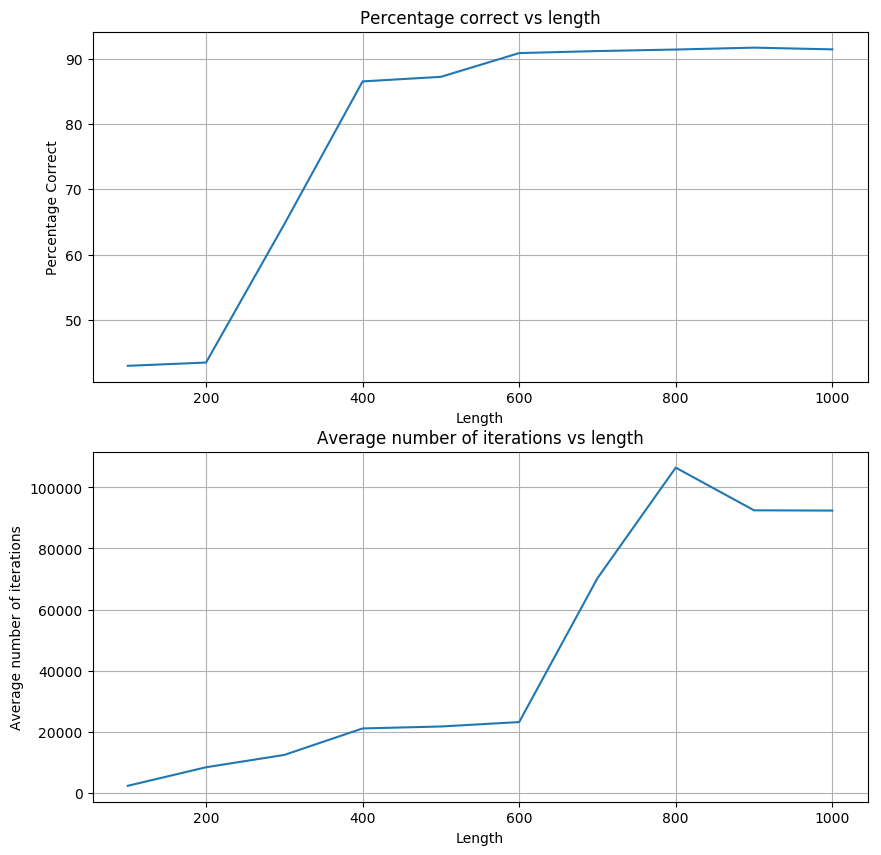

Number of steps: 500 Number of tries: 15


In [35]:
runSims("/Users/rishi/Project/test.txt",10,500,15)

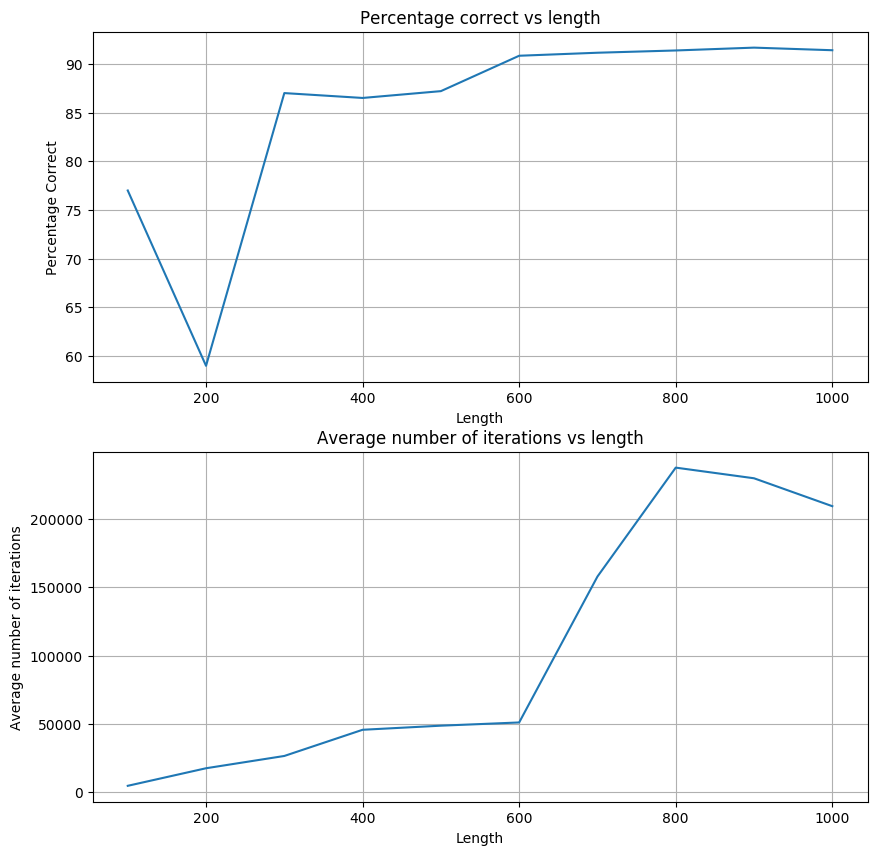

Number of steps: 1000 Number of tries: 15


In [36]:
runSims("/Users/rishi/Project/test.txt",10,1000,15)

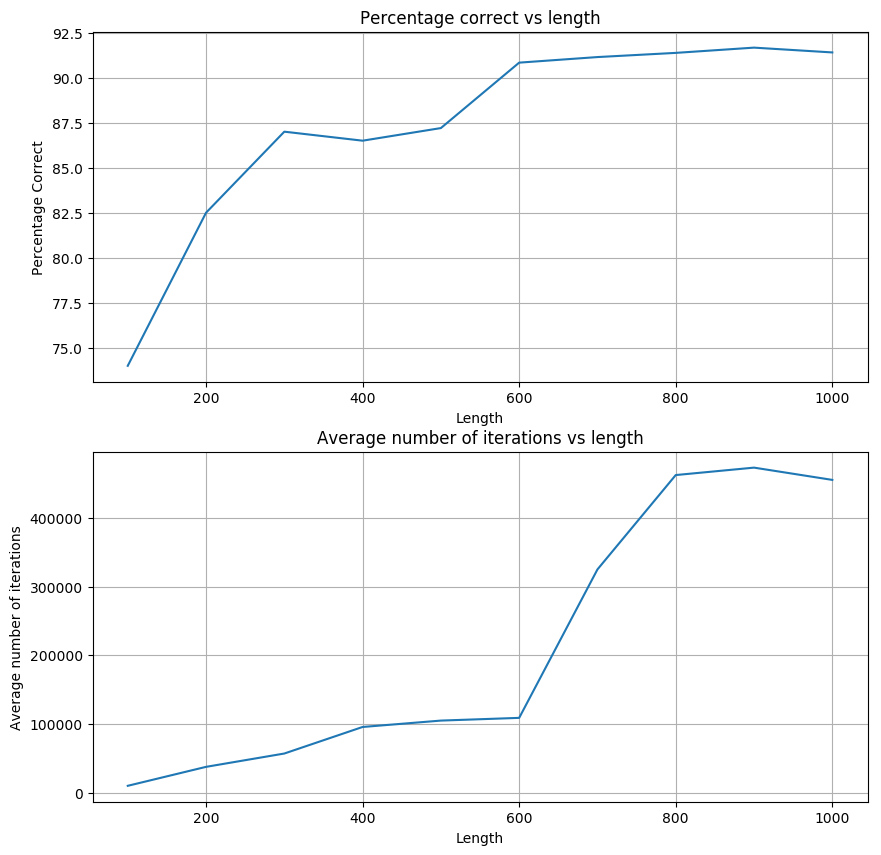

Number of steps: 2000 Number of tries: 15


In [37]:
runSims("/Users/rishi/Project/test.txt",10,2000,15)

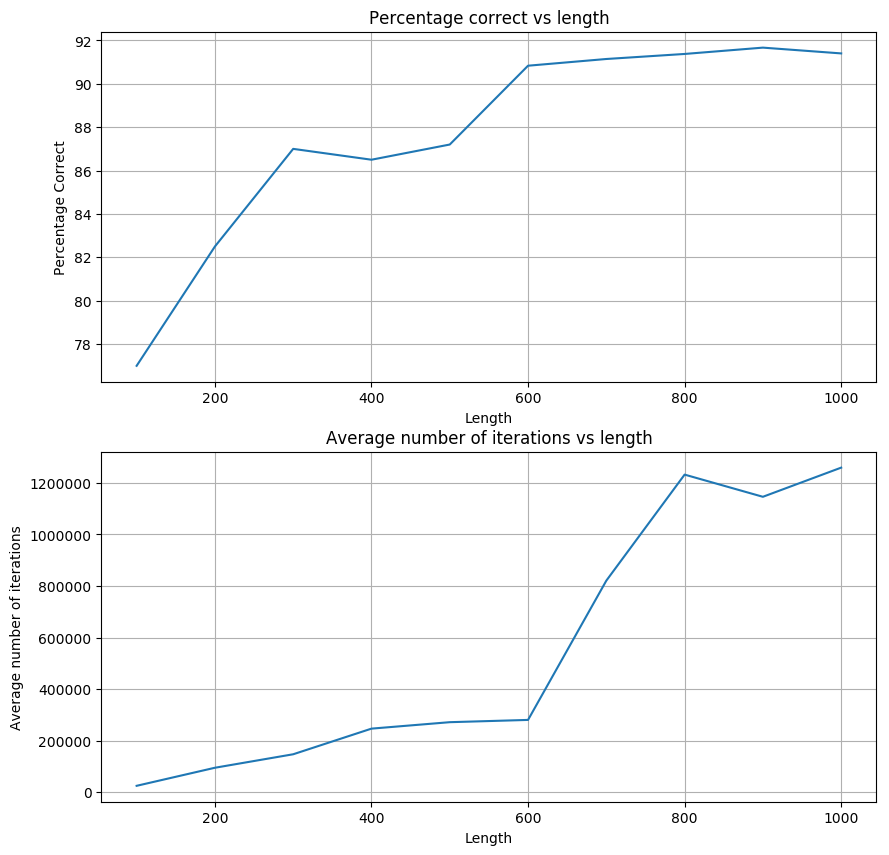

Number of steps: 5000 Number of tries: 15


In [38]:
runSims("/Users/rishi/Project/test.txt",10,5000,15)

In [39]:
runSims("/Users/rishi/Project/test.txt",10,10000,15)

Number of steps: 10000 Number of tries: 15


LoadError: InterruptException:

In [ ]:
runSims("/Users/rishi/Project/test.txt",10,20000,15)